In [203]:
import numpy as np
import matplotlib.pyplot as plt
from estimator import RFClassifier, relu
from data_fns import noisy_sin_signal, data_matrix_non_ov, butter_bandpass_filter
import dask

In [204]:
from dask.distributed import Client
client = Client(threads_per_worker=7, n_workers=10)
client

/home/bpandey/anaconda3/lib/python3.7/site-packages/distributed/dashboard/core.py:72: UserWarning: 
Port 8787 is already in use. 
Perhaps you already have a cluster running?
Hosting the diagnostics dashboard on a random port instead.
  warnings.warn("\n" + msg)


Client Scheduler: tcp://127.0.0.1:45789 Dashboard: http://127.0.0.1:34855/status,Cluster Workers: 10 Cores: 70 Memory: 135.06 GB


In [95]:
def bp_weights_gaus(M, N, lowcut, highcut, fs):
    W = np.zeros((M, N))

    t_points = np.arange(N) / fs
    wk = 2 * np.pi * np.arange(lowcut, highcut + 1)
    
    c = 1 / len(wk)
    Sk = 1
    for i in range(M):
        Ak = np.random.normal(size=(len(wk), 2))
        for j, t in enumerate(t_points):
            W[i, j] = c / np.sqrt(np.pi) * np.sum(Sk * (Ak[:, 0] * np.cos(wk * t) + Ak[:, 1] * np.cos(wk * t)))
    return W.T

def bp_weights(M, N, lowcut, highcut, fs):
    J = np.random.randn(M, N)
    J = butter_bandpass_filter(J, lowcut, highcut, fs)
    return J.T

def l_clf(classifier, params, X_train, y_train, X_test, y_test):
    clf = classifier(**params)
    clf.fit(X_train, y_train)
    return clf.score(X_test, y_test)

In [251]:
# generate data
fs, dur, sig_dur, f_signal = 2000, 500, 0.05, 20
a = 1
signal, label = noisy_sin_signal(f_s=fs, dur=dur, sig_dur=sig_dur, f_signal=f_signal, a=a)

delta = 0.07
N = int(delta * 2000)
X, y = data_matrix_non_ov(signal, label, N)

idx = int(len(X) * 2 / 3)
X_train, y_train = X[:idx], y[:idx]
X_test, y_test = X[idx:], y[idx:]

In [252]:
n_features = sorted(set(np.logspace(0, 3, 20).astype('int')))
print(n_features)

[1, 2, 4, 6, 8, 12, 18, 26, 37, 54, 78, 112, 162, 233, 335, 483, 695, 1000]


In [250]:
# W = bp_weights(20, N, 10, 20, fs)
# W_gaus = bp_weights_gaus(20, N, 10, 20, fs)
# fig = plt.figure()
# plt.plot(W.T[0], c='b', label='bp')
# plt.plot(W_gaus.T[0], c='r', label='bp gaus')
# plt.legend()

__Old method of bandpass weights vs the new gaussian formulation__ 

In [197]:
%%time 
lowcut, highcut = f_signal - 30, f_signal + 30
f = lambda M, N: bp_weights(M, N, lowcut=lowcut, highcut=highcut, fs=2000)
f_gaus = lambda M, N: bp_weights_gaus(M, N, lowcut=lowcut, highcut=highcut, fs=2000)

# band pass features
results_bp_gaus = []
results_bp = []
for n in n_features:
    params = {'width': n, 'weights': 'bandpass', 'weight_fun': f, 'nonlinearity': relu}
    lazy_results = [dask.delayed(l_clf)(RFClassifier, params, X_train, y_train, X_test, y_test) for _ in range(10)]
    results_bp.append(dask.compute(*lazy_results))
    
    params = {'width': n, 'weights': 'bandpass', 'weight_fun': f_gaus, 'nonlinearity': relu}
    lazy_results = [dask.delayed(l_clf)(RFClassifier, params, X_train, y_train, X_test, y_test) for _ in range(10)]
    results_bp_gaus.append(dask.compute(*lazy_results))

mean_bp = 1 - np.mean(results_bp, axis=1)
std_bp = np.std(results_bp, axis=1)

mean_bp_gaus = 1 - np.mean(results_bp_gaus, axis=1)
std_bp_gaus = np.std(results_bp_gaus, axis=1)

CPU times: user 17.2 s, sys: 6.65 s, total: 23.9 s
Wall time: 1min 39s


In [198]:
%%time 
# white noise features
results_whitenoise = []
for n in n_features:
    params = {'width': n, 'weights': 'white noise', 'nonlinearity': relu}
    lazy_results = [dask.delayed(l_clf)(RFClassifier, params, X_train, y_train, X_test, y_test) for _ in range(10)]
    results_whitenoise.append(dask.compute(*lazy_results))

mean_whitenoise = 1 - np.mean(results_whitenoise, axis=1)
std_whitenoise = np.std(results_whitenoise, axis=1)

CPU times: user 9.7 s, sys: 3.75 s, total: 13.5 s
Wall time: 53.5 s


In [199]:
%%time
# gaussian features
results_gaus= []
for n in n_features:
    params = {'width': n, 'weights': 'unimodal', 'nonlinearity': relu}
    lazy_results = [dask.delayed(l_clf)(RFClassifier, params, X_train, y_train, X_test, y_test) for _ in range(10)]
    results_gaus.append(dask.compute(*lazy_results))
    
mean_gaus = 1 - np.mean(results_gaus, axis=1)
std_gaus = np.std(results_gaus, axis=1)

CPU times: user 10.3 s, sys: 4.07 s, total: 14.4 s
Wall time: 54.7 s


(array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6]),
 <a list of 7 Text yticklabel objects>)

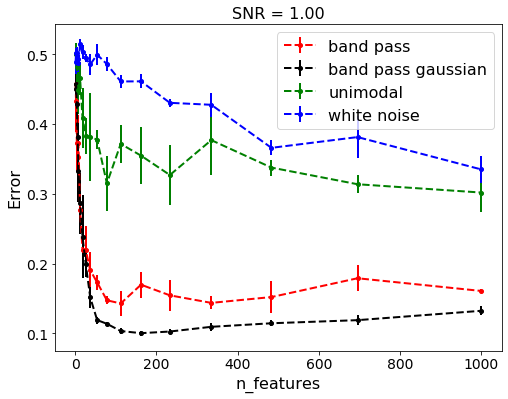

In [201]:
# plot
# snr = a ** 2 / (1 - a ** 2)
snr= 1
fig = plt.figure(figsize=(8, 6))
plt.title('SNR = %0.2f' % snr, fontsize=16)
plt.errorbar(n_features, mean_bp, yerr=std_bp, fmt='--ro', label='band pass', markersize=4, lw=2)
plt.errorbar(n_features, mean_bp_gaus, yerr=std_bp_gaus, fmt='--ko', label='band pass gaussian', markersize=4, lw=2)
plt.errorbar(n_features, mean_gaus, yerr=std_gaus, fmt='--go', label='unimodal', markersize=4, lw=2)
plt.errorbar(n_features, mean_whitenoise, yerr=std_whitenoise, fmt='--bo', label='white noise', markersize=4, lw=2)
plt.legend(fontsize=16)
plt.xlabel('n_features', fontsize=16)
plt.ylabel('Error', fontsize=16)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.savefig('figures/rand_classification/gaussian_bp/clf_a=%0.2f.png' % a)
plt.xlim([0, 100])
plt.savefig('figures/rand_classification/gaussian_bp/clf_a=%0.2f_zoomed.png' % a)

Plotting the fourier coefficients of positive vs the negative examples

In [253]:
import scipy

In [284]:
# generate data
fs, dur, sig_dur, f_signal = 2000, 400, 0.08, 40
a = 1
signal, label = noisy_sin_signal(f_s=fs, dur=dur, sig_dur=sig_dur, f_signal=f_signal, a=a)

delta = 0.1
N = int(delta * fs)
X, y = data_matrix_non_ov(signal, label, N)

idx = int(len(X) * 2 / 3)
X_train, y_train = X[:idx], y[:idx]
X_test, y_test = X[idx:], y[idx:]

In [285]:
delta * f_signal

4.0

In [286]:
X_positive = X_train[y_train == 1]
X_negative = X_train[y_train == 0]

In [287]:
A = scipy.linalg.dft(X_train.shape[1])

In [288]:
dft_positive = X_positive @ A
dft_negative = X_negative @ A

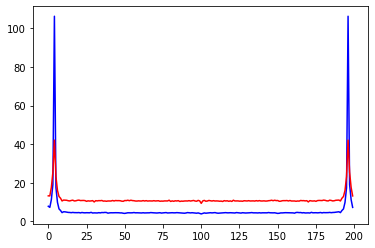

In [289]:
fig = plt.figure()
coef_positive = np.mean(np.abs(dft_positive), axis=0)
coef_negative = np.mean(np.abs(dft_negative), axis=0)
plt.plot(coef_positive, c='b')
plt.plot(coef_negative, c='r')

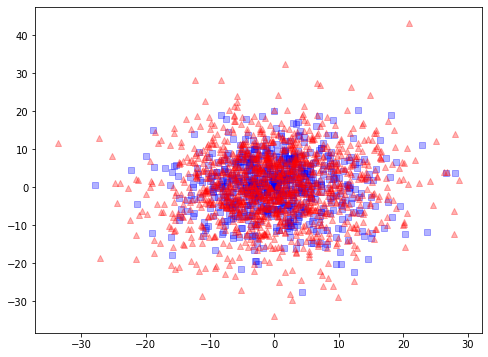

In [312]:
i = 20
fig = plt.figure(figsize=(8,6 ))
plt.scatter(dft_positive[:, i].real, dft_positive[:, i].imag, marker='s', c='b', alpha=0.3)
plt.scatter(dft_negative[:, i].real, dft_negative[:, i].imag, marker='^', c='r', alpha=0.3)

1